# **GAN Part 2: Application**
---
- 출제자 : 11기 김현진
- 기수/이름 : 송채은

StyleGAN의 Latent space에 원하는 이미지를 투영해 보고, image to image translation이 진행되는 과정을 살펴봅시다!

StyleGAN generator의 주요 구성 요소
1. Mapping Network
2. AdaIN
3. Noise Injection
4. Constant Input
5. Progressive Growing
6. Style Mixing

참고 논문: https://arxiv.org/pdf/1812.04948


### StyleGAN Generator Architecture

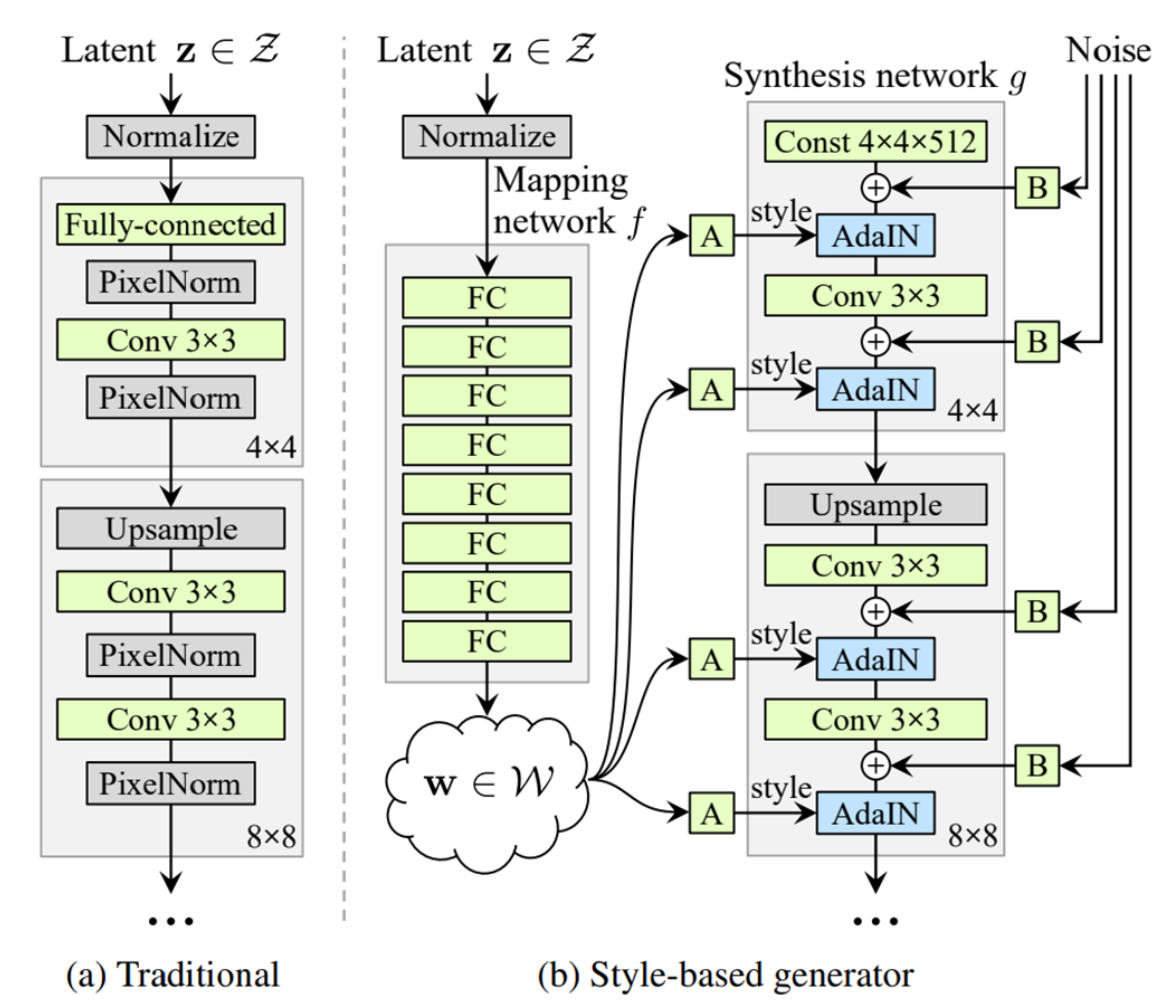


Latent vector(z 혹은 w): 인물의 스타일(style)을 담당 \
Noise Vector: 인물의 자잘한 특성(stochastic variation)을 담당

## **StyleGAN 실습**

### **라이브러리 임포트**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
# 소스코드 & pre-trained 모델 다운로드 (최초 한 번만 실행하셔도 됩니다!)
!git clone https://github.com/ohy2525/StyleGAN
%cd StyleGAN

# pre-trained 모델 압축 해제
# FFHQ는 1024 x 1024 고해상도 얼굴 이미지 데이터셋
!unzip weights/karras2019stylegan-ffhq-1024x1024.zip -d weights/

Cloning into 'StyleGAN'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77 (from 1)
Receiving objects: 100% (77/77), 95.46 MiB | 50.31 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/StyleGAN
Archive:  weights/karras2019stylegan-ffhq-1024x1024.zip
  inflating: weights/karras2019stylegan-ffhq-1024x1024.pt  


In [4]:
# FFHQ 데이터셋으로 학습된 StyleGAN의 두 가지 네트워크를 불러오기
from stylegan_model import G_mapping # 이미지를 잠재공간에 매핑(mapping)해주는 네트워크
from stylegan_model import G_synthesis # Latent vector를 이미지로 바꾸어주는 네트워크

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
resolution = 1024
weight_file = 'weights/karras2019stylegan-ffhq-1024x1024.pt'

# 네트워크 불러오기
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution = resolution))
]))
g_all.load_state_dict(torch.load(weight_file, map_location = device))
g_all.eval()
g_all.to(device)

g_mapping, g_synthesis = g_all[0], g_all[1]

### **함수 정의**
image_reader : 특정 경로에서 이미지를 불러와 tensor 형태로 변환하는 함수

In [5]:
def image_reader(image_path, resize = None):
    with open(image_path, "rb") as f:
        image = Image.open(f)
        image = image.convert("RGB")

    # 미리 정해진 해상도에 맞게 크기 변환
    if resize is not None:
        image = image.resize((resize, resize))

    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image)
    image = image.unsqueeze(0)  # 배치 목적의 차원 추가
    return image

imshow : tensor를 화면에 출력하는 함수

In [6]:
def imshow(tensor):

    image = tensor.cpu().clone()

    # 배치 목적의 차원을 제거
    image = image.squeeze(0)
    gray_scale = False
    if image.shape[0] == 1:
    	gray_scale = True

    # PLT 객체로 변경
    image = transforms.ToPILImage()(image)
    if gray_scale :
    	plt.imshow(image, cmap = 'gray')
    else :
    	plt.imshow(image)

    plt.show()

# 화면에 출력되는 이미지 크기 조절
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

* 랜덤한 이미지 생성하기

In [7]:
# 랜덤한 latent vector z를 샘플링하기
z = torch.randn((1, 512), requires_grad = False, device = device)

# Z에서 W 공간으로 매핑(mapping)
w = g_mapping(z)

# 만들어진 이미지는 [-1, 1]의 범위를 가지므로 이를 조정하여 시각화
image = g_synthesis(w)
image = ((image + 1.0) / 2.0).clamp(0, 1)

imshow(image)

## **StyleGAN의 잠재공간에 이미지 임베딩**

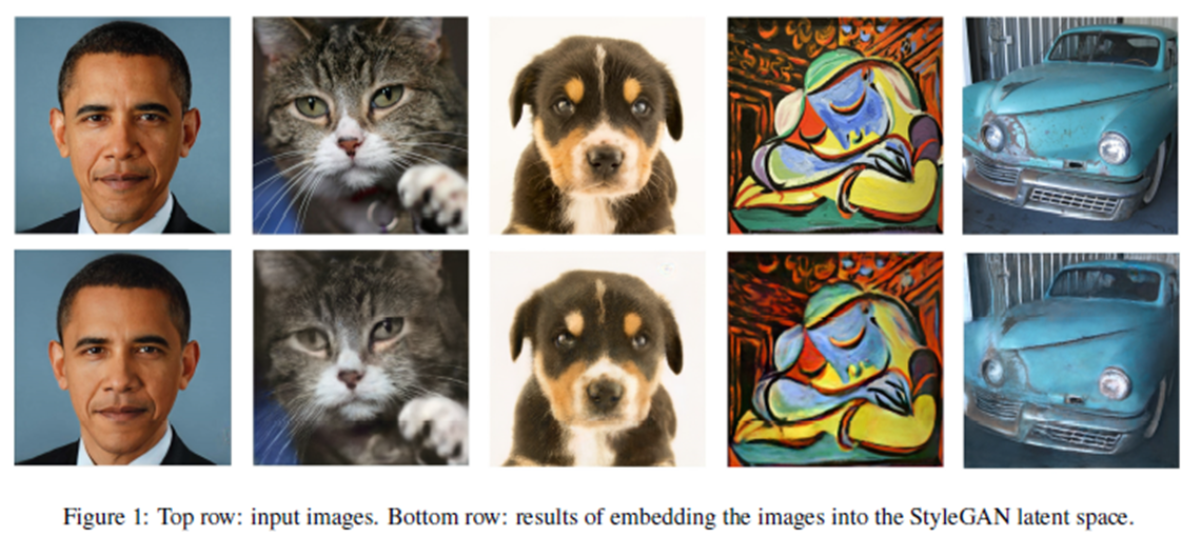

### **Image2StyleGAN** : 기존 StyleGAN이 가지는 한계를 극복하여 좀 더 일반적인 이미지 임베딩 기법 제시
--> 기존의 이미지 벡터와 잠재공간의 임베딩 벡터간의 유사도를 계산하여 StyleGAN의 잠재공간에 기존의 이미지 매핑

참고논문 : https://arxiv.org/pdf/1904.03189

### 임베딩 알고리즘
* 사전학습된 Generator에 주어진 이미지를 임베딩하기 위한 최적화 프레임워크 설정
* 최적화된 프레임워크를 통해 Latent vector w 최적화
 * 여기서 w는 주어진 이미지의 feature vector와 mapping network를 통해 만들어진 이미지 Latent vector와의 유사도를 근거로 loss를 최소화하는 벡터

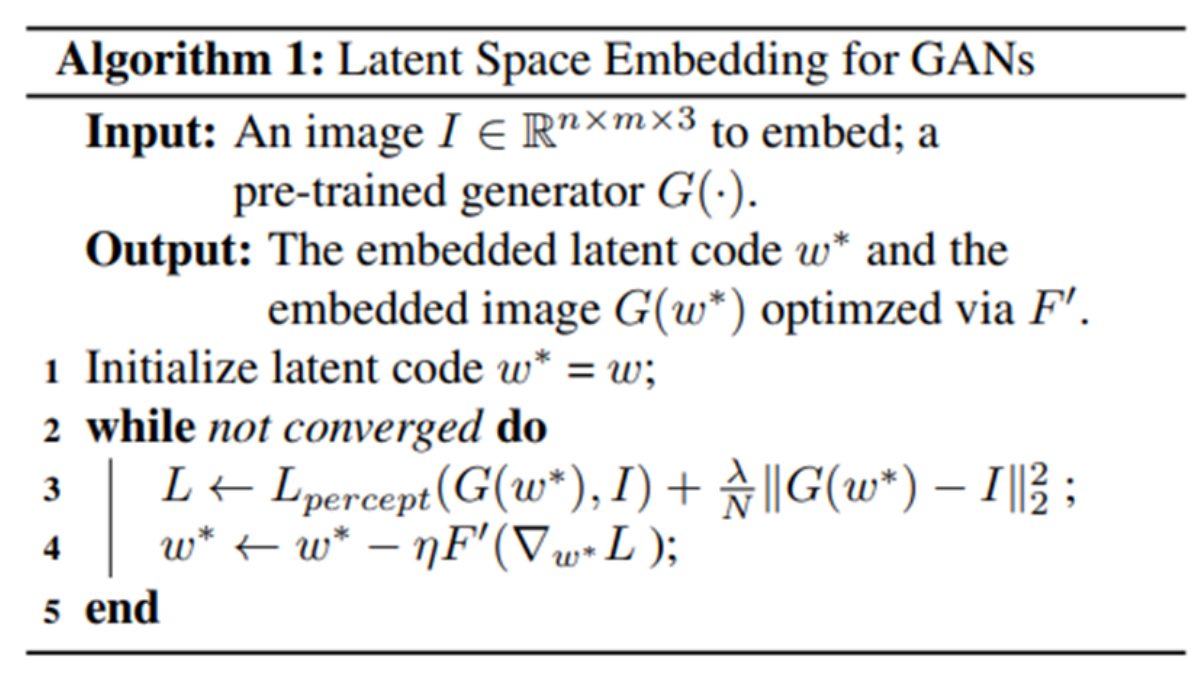

### Loss Function

* 입력 이미지와 임베딩된 이미지 간의 유사도 측정
* F 함수는 VGG16의 Convolution Layer를 의미함
* N : j번째 output의 scalar수, w: latent code
* 마지막 열의 이미지가 해당 방법론을 활용하여 복원한 이미임

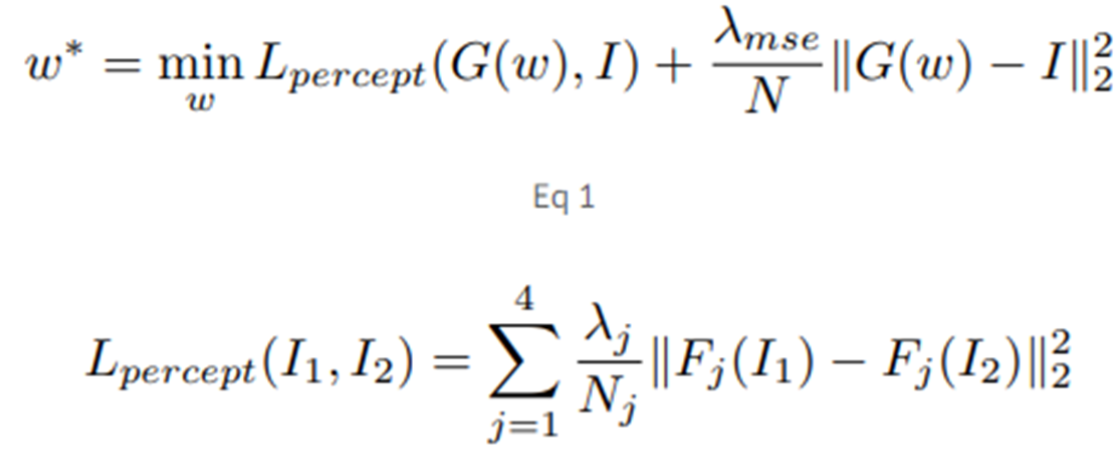

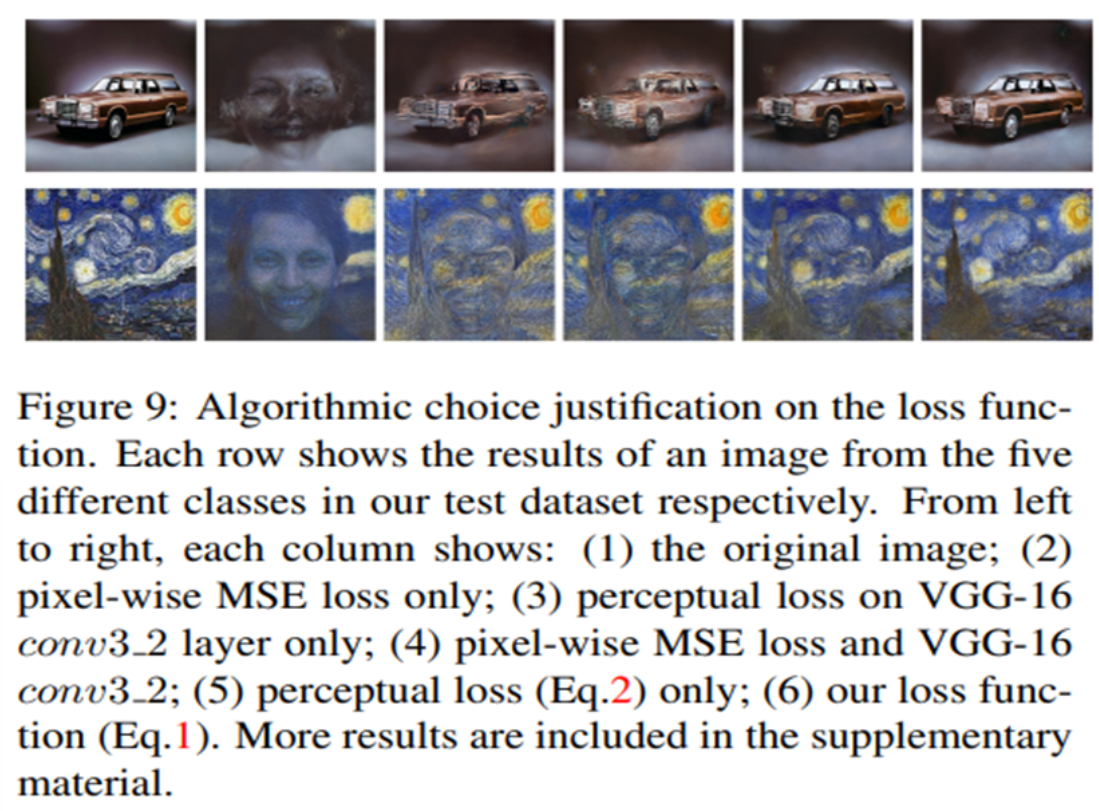

* VGG 네트워크를 활용한 이미지 특징 벡터 추출기

In [8]:
import warnings
warnings.filterwarnings(action = 'ignore')

# VGG를 활용한 특징 추출기(Feature Extractor)
class FeatureExtractor(torch.nn.Module):
    def __init__(self, n_layers):
        super(FeatureExtractor, self).__init__()
        extractor = models.vgg16(pretrained = True).features

        # 각 레이어까지의 출력 값을 계산 (n_layers=[1, 3, 13, 20])
        index = 0
        self.layers = nn.ModuleList([])

        for i in range(len(n_layers)):
            # 해당 레이어까지의 출력 값을 내보내기
            self.layers.append(torch.nn.Sequential())
            for j in range(index, n_layers[i] + 1):
                self.layers[i].add_module(str(j), extractor[j])
            index = n_layers[i] + 1

        # 모델을 학습할 필요는 없으므로 기울기 추적 중지
        for param in self.parameters():
            param.requires_grad = False

    # 각 레이어까지의 출력 값들을 리스트에 담아 반환
    def forward(self, x):
        result = []

        for i in range(len(self.layers)):
            x = self.layers[i](x)
            result.append(x)

        return result

* Perceptual Loss를 활용한 손실 함수 구현 (G(w)와 원본 이미지 사이에서 MSE 손실)

In [9]:
# 생성된 이미지(generated_image)와 대상 이미지(target_image, 내가 임베딩하고자 하는 이미지)에 대한 손실
def loss_function(generated_image, target_image, feature_extractor):
    MSE = nn.MSELoss(reduction = 'mean')
    mse_loss = MSE(generated_image, target_image) # 손실(loss) 값 계산

    # VGG 네트워크의 입력은 256이므로, 크기를 256으로 바꾸는 업샘플링(upsampling)을 이용
    upsample2d = torch.nn.Upsample(scale_factor = 256 / resolution, mode = 'bilinear')
    real_features = feature_extractor(upsample2d(target_image))
    generated_features = feature_extractor(upsample2d(generated_image))

    perceptual_loss = 0

    # 활성화 맵(activation map)의 개수만큼 반복
    for i in range(len(real_features)):
        perceptual_loss += MSE(real_features[i], generated_features[i]) # 손실(loss) 값 계산

    return mse_loss, perceptual_loss

* 이미지의 Latent Vector 학습
--> **해당 단계에서 두 개의 이미지에 대한 Latent Vector를 학습해 주세요.**

[iter 1/1500] loss = 8.874247550964355, saved_path = NJH_1.png
[iter 100/1500] loss = 3.6054961681365967, saved_path = NJH_100.png
[iter 200/1500] loss = 2.6806180477142334, saved_path = NJH_200.png
[iter 300/1500] loss = 2.1703271865844727, saved_path = NJH_300.png
[iter 400/1500] loss = 1.8990432024002075, saved_path = NJH_400.png
[iter 500/1500] loss = 1.6659337282180786, saved_path = NJH_500.png
[iter 600/1500] loss = 1.469741940498352, saved_path = NJH_600.png
[iter 700/1500] loss = 1.3807340860366821, saved_path = NJH_700.png
[iter 800/1500] loss = 1.3331165313720703, saved_path = NJH_800.png
[iter 900/1500] loss = 1.244866967201233, saved_path = NJH_900.png
[iter 1000/1500] loss = 1.2275121212005615, saved_path = NJH_1000.png
[iter 1100/1500] loss = 1.210415244102478, saved_path = NJH_1100.png
[iter 1200/1500] loss = 1.1254322528839111, saved_path = NJH_1200.png
[iter 1300/1500] loss = 1.126487374305725, saved_path = NJH_1300.png
[iter 1400/1500] loss = 1.0961358547210693, saved

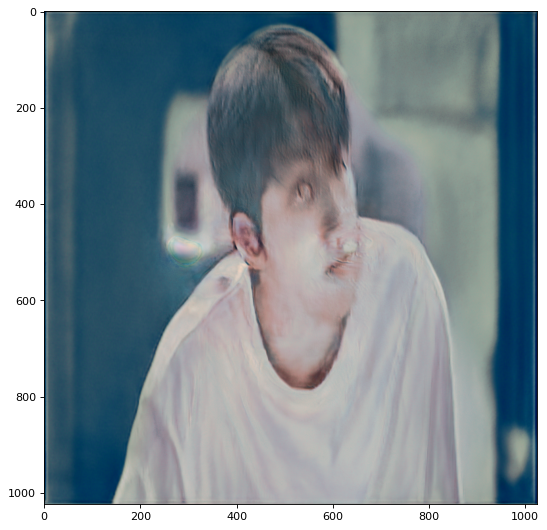

In [11]:
latent = torch.zeros((1, 18, 512), requires_grad = True, device = device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr = 0.02, betas = (0.9, 0.999), eps = 1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers = [1, 3, 13, 20]).to(device)

# 이미지 불러오기
src = '/content/NJH.jpg' # 본인이 생성하거나 스타일을 바꾸고 싶은 이미지를 넣어 주세요 (두 개의 이미지에 대한 Latent vector 생성기)
name = 'NJH'

image = image_reader(src, resize = resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500   # 논문은 5000 .. 오래 걸려용

for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

In [12]:
latent = torch.zeros((1, 18, 512), requires_grad = True, device = device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr = 0.02, betas = (0.9, 0.999), eps = 1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers = [1, 3, 13, 20]).to(device)

src = '/content/IU.jpg'
name = "IU"

image = image_reader(src, resize = resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500   # 논문은 5000 .. 오래 걸려용

for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

[iter 1/1500] loss = 8.23626708984375, saved_path = IU_1.png
[iter 100/1500] loss = 2.910656452178955, saved_path = IU_100.png
[iter 200/1500] loss = 1.9096927642822266, saved_path = IU_200.png
[iter 300/1500] loss = 1.4977741241455078, saved_path = IU_300.png
[iter 400/1500] loss = 1.245060920715332, saved_path = IU_400.png
[iter 500/1500] loss = 1.0579841136932373, saved_path = IU_500.png
[iter 600/1500] loss = 0.9746749997138977, saved_path = IU_600.png
[iter 700/1500] loss = 0.9046090841293335, saved_path = IU_700.png
[iter 800/1500] loss = 0.8853764533996582, saved_path = IU_800.png
[iter 900/1500] loss = 0.8608789443969727, saved_path = IU_900.png
[iter 1000/1500] loss = 0.8059322834014893, saved_path = IU_1000.png
[iter 1100/1500] loss = 0.7927684187889099, saved_path = IU_1100.png
[iter 1200/1500] loss = 0.7795552015304565, saved_path = IU_1200.png
[iter 1300/1500] loss = 0.7264208793640137, saved_path = IU_1300.png
[iter 1400/1500] loss = 0.7400354743003845, saved_path = IU_14

* 두 이미지 간 morphing 구현

[ 이미지 보간법(Interpolation) ]


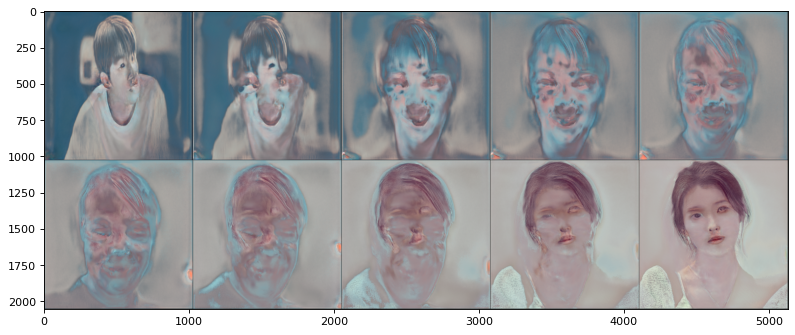

[ 이미지 보간법(Interpolation) ]


In [21]:
print('[ 이미지 보간법(Interpolation) ]')

# .npy 파일로부터 두 w 벡터 불러오기
w_1 = np.load("NJH_latent.npy")
w_2 = np.load("IU_latent.npy")

name = 'interpolation'
interpolated_images = []

# 두 벡터간 모핑(morphing) 수행하기
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w, dtype=torch.float32).to(device)  # dtype 명시
        w = torch.tensor(w).to(device)
        image = g_synthesis(w)
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# 결과 이미지를 격자(grid) 형태로 저장
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim = 0), nrow = 5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

print('[ 이미지 보간법(Interpolation) ]')




* 웃는 얼굴, 무표정 얼굴 이미지 Latent vector 추출

In [22]:
latent = torch.zeros((1, 18, 512), requires_grad = True, device = device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr = 0.02, betas = (0.9, 0.999), eps = 1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers = [1, 3, 13, 20]).to(device)

# 이미지 불러오기
# 해당 이미지가 아니어도 같은 배경, 같은 위치의 표정이 다른 얼굴 이미지를 갖고 시행 가능
src = 'images/face_smile.bmp'
name = 'face_smile'
#src = '/content/NJH.jpg'
#name = 'NJH'
image = image_reader(src, resize = resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500

for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

[iter 1/1500] loss = 6.403165340423584, saved_path = face_smile_1.png
[iter 100/1500] loss = 0.5586475133895874, saved_path = face_smile_100.png
[iter 200/1500] loss = 0.4173981547355652, saved_path = face_smile_200.png
[iter 300/1500] loss = 0.3089609444141388, saved_path = face_smile_300.png
[iter 400/1500] loss = 0.27352893352508545, saved_path = face_smile_400.png
[iter 500/1500] loss = 0.24001656472682953, saved_path = face_smile_500.png
[iter 600/1500] loss = 0.214808851480484, saved_path = face_smile_600.png
[iter 700/1500] loss = 0.21714818477630615, saved_path = face_smile_700.png
[iter 800/1500] loss = 0.2049144059419632, saved_path = face_smile_800.png
[iter 900/1500] loss = 0.19375264644622803, saved_path = face_smile_900.png
[iter 1000/1500] loss = 0.1856631487607956, saved_path = face_smile_1000.png
[iter 1100/1500] loss = 0.1869206428527832, saved_path = face_smile_1100.png
[iter 1200/1500] loss = 0.16842348873615265, saved_path = face_smile_1200.png
[iter 1300/1500] los

[iter 1/1500] loss = 6.327961444854736, saved_path = face_neutral_1.png
[iter 100/1500] loss = 0.4891264736652374, saved_path = face_neutral_100.png
[iter 200/1500] loss = 0.2947927415370941, saved_path = face_neutral_200.png
[iter 300/1500] loss = 0.22983039915561676, saved_path = face_neutral_300.png
[iter 400/1500] loss = 0.20406726002693176, saved_path = face_neutral_400.png
[iter 500/1500] loss = 0.19672931730747223, saved_path = face_neutral_500.png
[iter 600/1500] loss = 0.17156274616718292, saved_path = face_neutral_600.png
[iter 700/1500] loss = 0.16275718808174133, saved_path = face_neutral_700.png
[iter 800/1500] loss = 0.16262955963611603, saved_path = face_neutral_800.png
[iter 900/1500] loss = 0.14750586450099945, saved_path = face_neutral_900.png
[iter 1000/1500] loss = 0.1371523141860962, saved_path = face_neutral_1000.png
[iter 1100/1500] loss = 0.13666121661663055, saved_path = face_neutral_1100.png
[iter 1200/1500] loss = 0.13334010541439056, saved_path = face_neutra

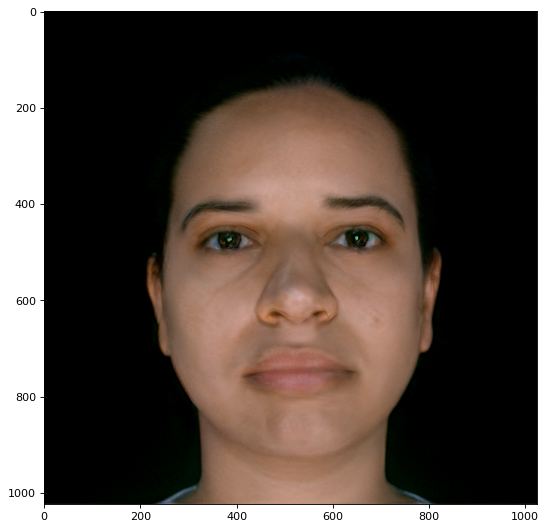

In [23]:
latent = torch.zeros((1, 18, 512), requires_grad = True, device = device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr = 0.02, betas = (0.9, 0.999), eps = 1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers = [1, 3, 13, 20]).to(device)

# 이미지 불러오기
# 해당 이미지가 아니어도 같은 배경, 같은 위치의 표정이 다른 얼굴 이미지를 갖고 시행 가능
#src = '/content/IU.jpg'
#name = 'IU'
src = 'images/face_neutral.bmp'
name = 'face_neutral'
image = image_reader(src, resize=resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500

for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

* 임베딩 벡터 연산
: Latent Vector간의 연산 수행
웃는 얼굴에서 무표정 얼굴을 빼 웃는 얼굴에 대한 semantic 정보 획득

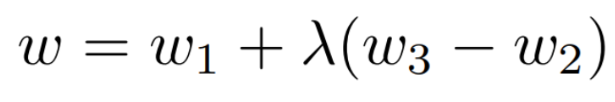

In [18]:
# 웃는 얼굴 임베딩 불러오기
smile_latent = np.load('face_smile_latent.npy')
#smile_latent = np.load('NJH_latent.npy')

# 무표정 얼굴 임베딩 불러오기
#neutral_latent = np.load('IU_latent.npy')
neutral_latent = np.load('face_neutral_latent.npy')

# 벡터 연산 수행하기
smile_direction = smile_latent - neutral_latent

* 웃는 얼굴 편집

In [19]:
interpolated_images = []

name = 'smile'
target_latent = np.load('NJH_latent.npy')

with torch.no_grad():
    for alpha in np.linspace(0, 0.2, 10):
        w = target_latent + alpha * smile_direction # 웃는 방향으로 벡터 이동
        w = torch.tensor(w).to(device)
        w = torch.tensor(w, dtype=torch.float32).to(device)  # dtype 명시
        image = g_synthesis(w)
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim = 0), nrow = 5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

* 무표정 얼굴 편집

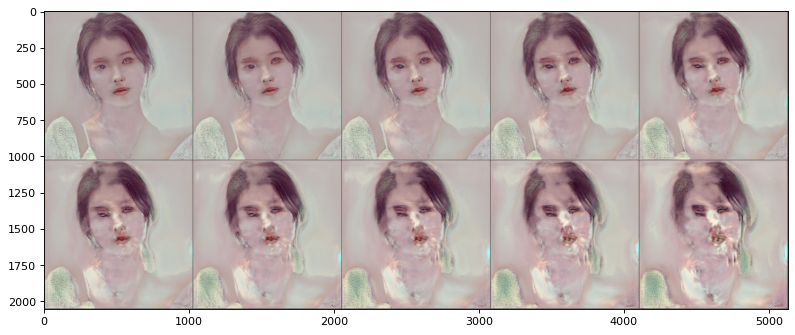

In [20]:
interpolated_images = []

name = 'straight'
target_latent = np.load('IU_latent.npy')

with torch.no_grad():
    for alpha in np.linspace(0, 0.2, 10):
        w = target_latent - alpha * smile_direction # 웃지 않는 방향으로 벡터 이동
        w = torch.tensor(w).to(device)
        w = torch.tensor(w, dtype=torch.float32).to(device)  # dtype 명시
        image = g_synthesis(w)
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim = 0), nrow = 5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

수고하셨습니다!


여기까지가 이번 세션의 과제까지 모든 끝입니다.


긴 시간 동안 모두 고생 많으셨고, 학술부의 횡포(?)를 끝까지 따라와주어 너무나 감사합니다.


남은 학기, 그리고 학회 활동까지 마저 힘내시고, 행운이 깃들시길 진심으로 기원합니다.

12기 김민규